In [1]:
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from keras import optimizers
from keras import losses
from keras import metrics
import keras_tuner
import matplotlib.pyplot as plt

---

Завантажемо наш датасет:

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
train_images.shape, type(train_images[0]), train_images[0].shape

((60000, 28, 28), numpy.ndarray, (28, 28))

In [4]:
test_images.shape, type(test_images[0]), test_images[0].shape

((10000, 28, 28), numpy.ndarray, (28, 28))

In [5]:
# Масштабуємо та перетворюємо дані
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [6]:
# Функція для виведення графіків loss функції та точності на валідаційній вибірці
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(history_dict['accuracy']) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()
    val_acc_values = history_dict['val_accuracy']
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

---

Створимо наступну архітектуру для нашої моделі. Також використаєм Categorical Crossentropy, оскільки ми перетворили наші лейбли в категоріальні дані:

In [7]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(10, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,058 (414.29 KB)

 Trainable params: 106,058 (414.29 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Додамо Early Stopping задля запобігання перенавчанню:

In [10]:
early_stopping = EarlyStopping(
    monitor="val_loss",  
    patience=5,         
    restore_best_weights=True
)

Epoch 1/20


I0000 00:00:1731895227.142753      98 service.cc:145] XLA service 0x7d963c0020a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731895227.142797      98 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731895227.142801      98 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 69/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2931 - loss: 1.9623

I0000 00:00:1731895231.380642      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6392 - loss: 0.9854 - val_accuracy: 0.8435 - val_loss: 0.4302
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8539 - loss: 0.4120 - val_accuracy: 0.8816 - val_loss: 0.3091
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8794 - loss: 0.3332 - val_accuracy: 0.8926 - val_loss: 0.2918
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8925 - loss: 0.2979 - val_accuracy: 0.9039 - val_loss: 0.2634
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9005 - loss: 0.2748 - val_accuracy: 0.8947 - val_loss: 0.2726
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9098 - loss: 0.2489 - val_accuracy: 0.9082 - val_loss: 0.2472
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9141 - loss: 0.2307 - val_accuracy: 0.9057 - val_loss: 0.2504
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9192 - loss: 0.2205 - val_accuracy: 0.9006 - val

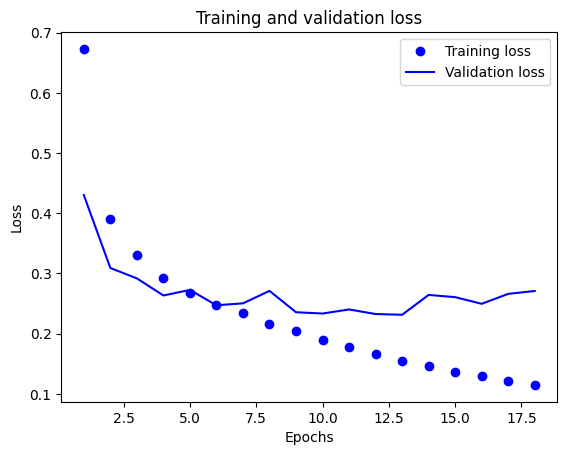

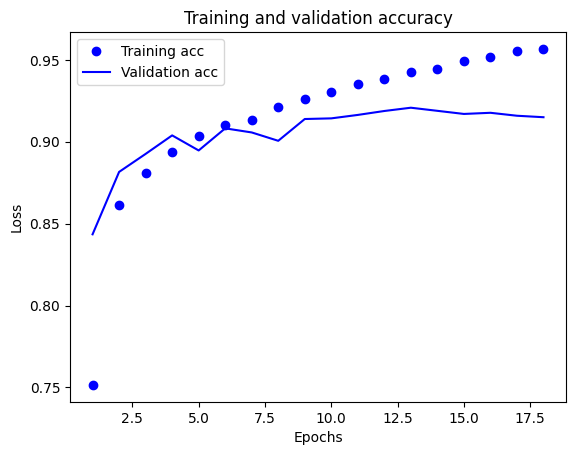

In [11]:
x_val = train_images[:10000]
partial_x_train = train_images[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

plot_history(history)

In [12]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9173 - loss: 0.2681
0.9169999957084656


---

Результат непоганий, але спробуємо знайти оптимальніші параметри з keras tuner:

In [13]:
def build_model(hp):
    model = Sequential([
        Conv2D(hp.Choice('conv1_filters', [16, 32]), (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),

        Conv2D(hp.Choice('conv2_filters', [32, 64]), (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(hp.Choice('dense_units', [64, 128, 256]), activation='relu'),
        Dropout(hp.Choice('dropout_value', [0.2, 0.5])),

        Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [14]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=4)

tuner.search(partial_x_train, partial_y_train, epochs=15, validation_data=(x_val, y_val))

Trial 4 Complete [00h 01m 08s]
val_accuracy: 0.9168999791145325

Best val_accuracy So Far: 0.9176999926567078
Total elapsed time: 00h 04m 38s


In [15]:
best_model = tuner.get_best_models()[0]

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:
best_model.fit(partial_x_train, partial_y_train, epochs=15, validation_data=(x_val, y_val))

Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9562 - loss: 0.1156 - val_accuracy: 0.9176 - val_loss: 0.2744
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9603 - loss: 0.1068 - val_accuracy: 0.9109 - val_loss: 0.3340
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9616 - loss: 0.1006 - val_accuracy: 0.9136 - val_loss: 0.3127
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9647 - loss: 0.0913 - val_accuracy: 0.9147 - val_loss: 0.3134
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9676 - loss: 0.0873 - val_accuracy: 0.9167 - val_loss: 0.3179
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9701 - loss: 0.0794 - val_accuracy: 0.9105 - val_loss: 0.3402
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9703 - loss: 0.0773 - val_accuracy: 0.9158 - val_loss: 0.3334
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9724 - loss: 0.0757 -

In [17]:
test_loss, test_acc = best_model.evaluate(test_images, test_labels)
print(test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9155 - loss: 0.4527
0.9146000146865845


__Висновок:__ пошук параметрів дав схожий результат на тестовій вибірці, тому можна сказати, що найкраща модель і є та, з якої ми почали. Порівнянно з моделью з попереднього завдання без згорток, точність трохи покращилась. Тобто згорткові моделі дійсно дають можливисть краще розв'язувати задачі з класифікацією зображень.